# Using `bmfm-multi-omics` for cell type annotation

Assinging cell type annotations is an import and time consuming part of single-cell analysis. BMFM-RNA simplifies this process by not only performing the cell-type annotation but also the preprocessing and visualisation through the embeddings created by the model.

In [ ]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import scanpy as sc
import torch

from bmfm_targets import config
from bmfm_targets.evaluation import (
    check_gpu,
    create_results_obs,
    generate_clusters,
    get_general_cell_type,
    get_label_map,
    merge_bmfm_adata,
    plot_cell_type_counts,
    plot_embeddings,
    plot_logits,
)
from bmfm_targets.tasks.task_utils import (
    instantiate_module_from_checkpoint,
    make_trainer_for_task,
    predict,
)
from bmfm_targets.tokenization import load_tokenizer
from bmfm_targets.training.modules import (
    DataModule,
)

DEVICE = check_gpu()

/Users/mattmadgwick/miniforge3/envs/biomed-multi-omic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS


## Load Example Data

To demostrate the BMFM-RNAs abilites, we use the PBMC data created by 10X Genomics (dataset can be downloaded [here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). This dataset is created of 3k PBMCs from a Healthy Donor. The raw data will be used as the input, but we will also extract the cell type annotation from the legacy scanpy workflow as a comparison between the BMFM and classical scRNA-seq analysis. 

For more information about how the data was preprocessing please visit scanpy's tutorial [here](https://scanpy.readthedocs.io/en/1.11.x/tutorials/basics/clustering-2017.html).

In [2]:
# Get raw PBMC3k data
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

# Get PMBC3k raw dataset
adata = sc.datasets.pbmc3k()

# Extract reference data for later downstream comparison
reference_adata = sc.datasets.pbmc3k_processed()
reference_labels = reference_adata.obs[["louvain"]]
reference_obs_index = reference_adata.obs.index.tolist()
reference_vars_index = reference_adata.var.index.tolist()

adata = adata[reference_obs_index, reference_vars_index]
adata.write("data/pbmc3k_raw.h5ad")

Create results directory to save predictions and plots.

In [3]:
# Create results directory
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

## Load checkpoint

To load a model checkpoint, you can either provide a local path or a model id from the Hugging Face model repository: https://huggingface.co/ibm-research 

The model used for this tutorial: [ibm-research/bmfm.rna.bert.110m.wced.multitask.v1](https://huggingface.co/ibm-research/biomed.rna.bert.110m.wced.v1)

To get the model loaded you can use either:
1. Local Path: download the model checkpoints and tokenizer from huggingface
2. Hugging Face Repo: using  `ibm-research/bmfm.rna.bert.110m.wced.multitask.v1`

The model checkpoint has the following keys:

- `epoch`: This key stores the current epoch number during training.
- `global_step`: This key stores the current global step number during training.
- `pytorch-lightning_version`: This key stores the version of PyTorch Lightning used to save the checkpoint.
- `state_dict`: This key stores the model's state dictionary, which contains the model's parameters (weights and biases).
- `loops`: This key stores the list of training loops that were executed during the training process.
- `callbacks`: This key stores the list of callbacks that were executed during the training process.
- `optimizer_states`: This key stores the optimizer's state dictionary, which includes the optimizer's internal state, such as the current step, momentum, and learning rate.
- `lr_schedulers`: This key stores the learning rate scheduler's state dictionary, which includes the scheduler's internal state, such as the current epoch or step.
- `MixedPrecision`: This key stores the mixed precision settings used during training, if any.
- `hparams_name`: This key stores the name of the hyperparameter configuration used for training.
- `hyper_parameters`: This key stores a dictionary of hyperparameters such as 'model_config', 'trainer_config', and 'label_dict'. 


In both cases, the model's configuration will be automatically loaded. If you want to use a specific configuration, you can provide these parameters later in the `task_config`.

In [4]:
# Load the checkpoint locally
model_path = Path("wced_1024_multitask")
checkpoint_path = model_path / "last.ckpt"

cpkt = torch.load(
    checkpoint_path,
    map_location=torch.device(DEVICE),
    weights_only=False,
)

label_dict = cpkt["hyper_parameters"]["label_dict"]
model_config = cpkt["hyper_parameters"]["model_config"]

tokenizer = load_tokenizer(model_path)

## Create Data, Trainer and Task Configs

Once the model checkpoint and tokenizer have been loaded, you will need to setup the data loader for your data. The easiest way to load your data is to save your data as an H5AD object and then provide the path to the data in the `dataset_kwargs` under the key `processed_data_source`. 

Importantly, as we are using the checkpoint for WCED model (`ibm-research/bmfm.rna.bert.110m.wced.multitask.v1`) you will need to ensure that `adata.X` is raw counts. The data module will then handle any transformation for you including limited the genes to protein coding genes only.

Finally, as we want to perform zeroshot, we will need to setup the our data module in predict model by using `data_module.setup("predict")`.

In [5]:
data_module = DataModule(
    data_dir="data",
    transform_datasets=False,
    tokenizer=tokenizer,
    fields=model_config.fields,
    limit_genes="protein_coding",
    mlm=False,
    collation_strategy="multitask",
    batch_size=20,
    pad_zero_expression_strategy="batch_wise",
    dataset_kwargs={
        "processed_data_source": "data/pbmc3k_raw.h5ad",
        "expose_zeros": "all",
    },
    transform_kwargs={},
    num_workers=1,
    log_normalize_transform=True,
)
data_module.setup("predict")

str arguments for `pad_zero_expression_strategy` are deprecated
batch_wise -> {'strategy': 'batch_wise'}


Next we need to set up the trainer and task configs.

The trainer config will need to be provided any of the labels you want to predict under the `losses` parameter. In this case we are predicting `cell_type`. However, the multitask model can also predict other labels such as `tissue` and `tissue_general`. For a full is of losses you can inspect the model's checkpoint using: 
```python 
cpkt["hyper_parameters"]["trainer_config"].losses
```

The task config needs to be provided with the model checkpoint path we created eariler. The DEVICE in this case is set based on the detected hardware on your machine. Finally, we create the pytorch lighting 

*NB: `"16-mixed"` if using CUDA rather than `32` on CPU or MPS

In [6]:
trainer_config = config.TrainerConfig(
    losses=[{"label_column_name": "cell_type"}], batch_size=20
)

task_config = config.PredictTaskConfig(
    checkpoint=str(checkpoint_path),
    default_root_dir=".",
    precision="32",  # "16-mixed" if using CUDA rather than CPU or MPS
    accelerator=DEVICE,
    output_embeddings=True,
    output_predictions=True,
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[],
)

pl_trainer = make_trainer_for_task(task_config)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Initialize model from checkpoint with task config, data module, model config and the trainer config.

In [7]:
pl_module = instantiate_module_from_checkpoint(
    task_config, data_module, model_config, trainer_config
)

Tie weights not supported for this model


In [8]:
type(pl_module)

bmfm_targets.training.modules.multitask_modeling.MultiTaskTrainingModule

## Run predict

How the data module, task config, model config and tranier config have been instantiated to a MultiTaskTrainingModule.

Then we can use the `predict` function with the trainer, MultiTaskTrainingModule and data module to perform our zero-shot.

In [9]:
results = predict(
    pl_trainer=pl_trainer, pl_module=pl_module, pl_data_module=data_module
)

/Users/mattmadgwick/miniforge3/envs/biomed-multi-omic/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0:   0%|          | 0/132 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicting DataLoader 0: 100%|██████████| 132/132 [01:59<00:00,  1.10it/s]


The complete mapping dictionary of the label codes to the actual cell label names can be converted using the `get_label_map` helper function:

In [10]:
label_map = get_label_map(key="cell_type", predictions=results, label_dict=label_dict)

# Show the first few labels mapped to cell-types
list(label_map.items())[:4]

[(0, 'B cell'),
 (8, 'CD14-positive monocyte'),
 (11, 'CD14-positive, CD16-positive monocyte'),
 (13, 'CD16-negative, CD56-bright natural killer cell, human')]

## Plot embeddings

To view the embeddings and paint the cell-type annotations on the UMAP the embeddings will be extracted from the results. 

First we need to convert the embeddings and barcode names into a adata object. This can be done using the `create_results_obs`. Then you can run unsupervised clustering and UMAP projection on the embeddings from inference step.


/Users/mattmadgwick/miniforge3/envs/biomed-multi-omic/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


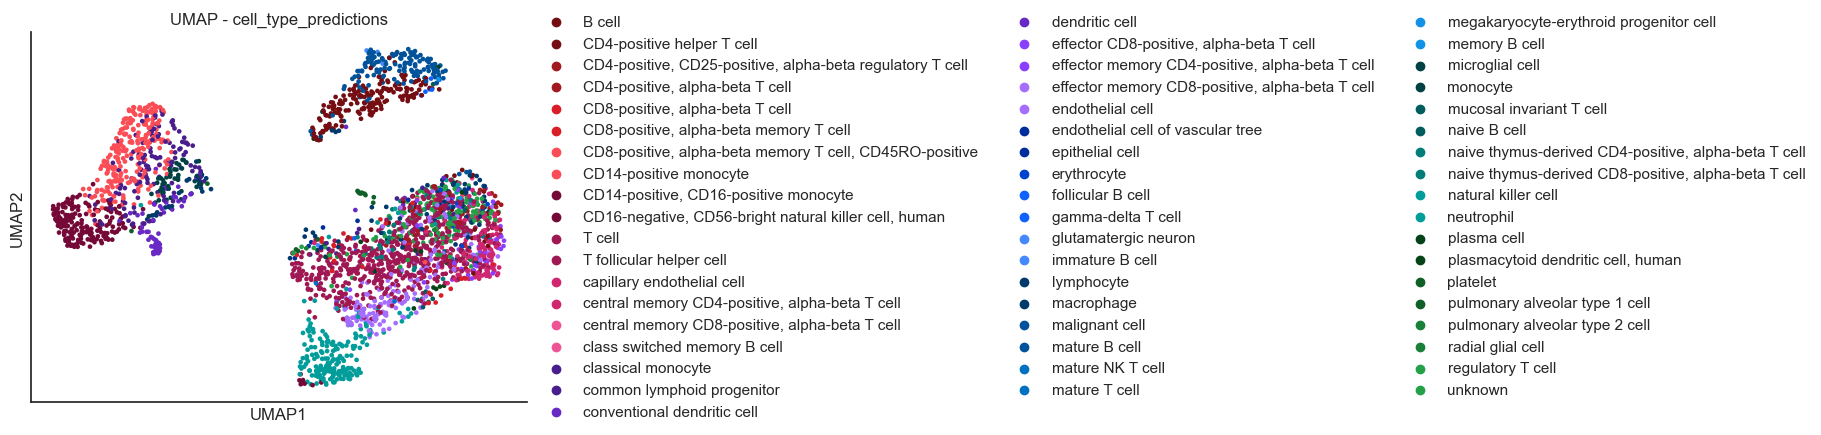

In [11]:
adata = create_results_obs(results=results, label_dict=label_dict)
adata = generate_clusters(
    adata,
    n_components=20,
    label="cell_type_predictions",
    clustering_method="kmeans",
    n_clusters=11,
)

plot_embeddings(adata, "cell_type_predictions")

The `bmfm.rna.bert.110m.wced.multitask.v1` model is trained on the most coarse cell labels as defined by the data on CellXGene. 

In some cases you may want to try and generalize the cell labels. To do this you can use the helper function `get_general_cell_type` and set the level to `sub_class` to try and get a more refined labelling of the cells.

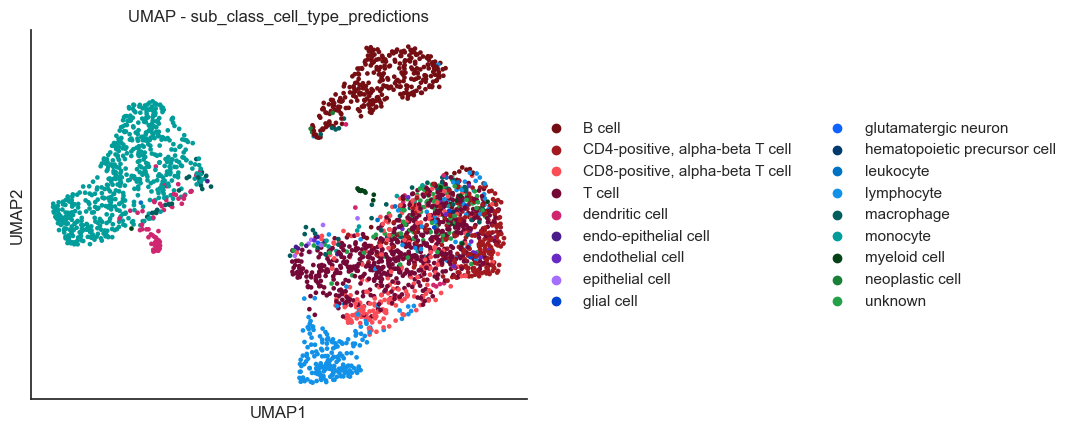

In [12]:
adata = get_general_cell_type(adata, label_dict, level="sub_class")
plot_embeddings(adata, "sub_class_cell_type_predictions")

The original labelling of the PMBC3K dataset can then also be projected onto the UMAP here as the ground truth labels to observe the how similar the are to the predicted cell type labels.

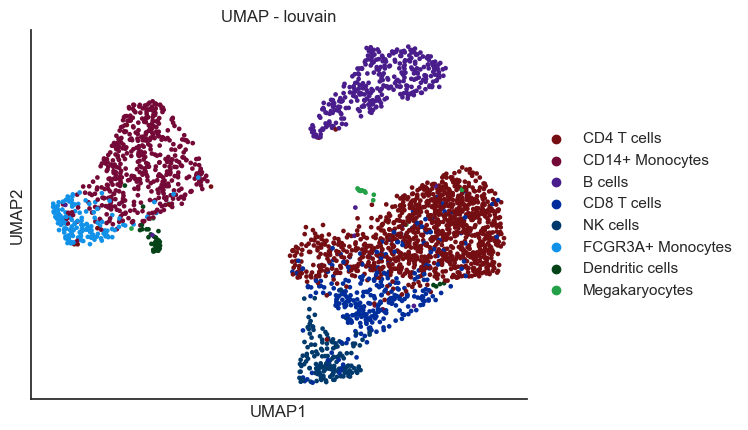

In [13]:
adata.obs = adata.obs.join(reference_labels, how="left")
plot_embeddings(adata, "louvain")

We can then compare the cell counts between our ground truth labels and our sub-class summarized predicted labels from the model:

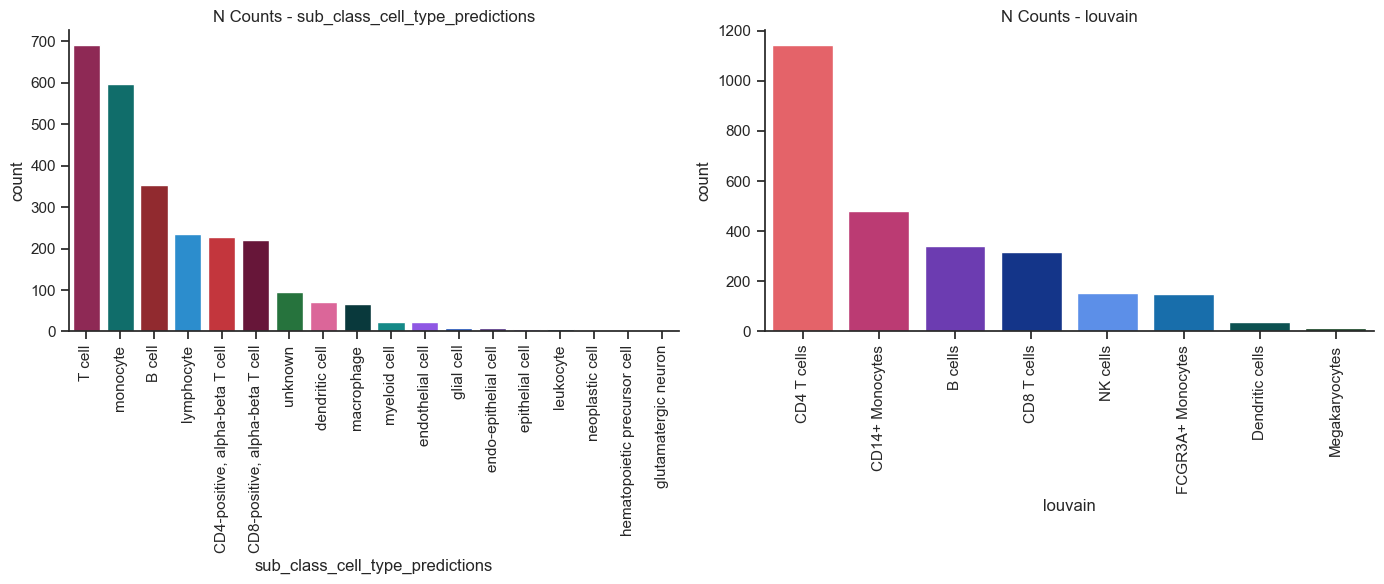

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_cell_type_counts(adata, "sub_class_cell_type_predictions", ax=axes[0], show=False)
plot_cell_type_counts(adata, "louvain", ax=axes[1], show=False)
plt.tight_layout()
plt.show()

## Plotting Logits

You can observe the prediction for each individual cell using the logits from the checkpoint.

/Users/mattmadgwick/miniforge3/envs/biomed-multi-omic/lib/python3.12/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


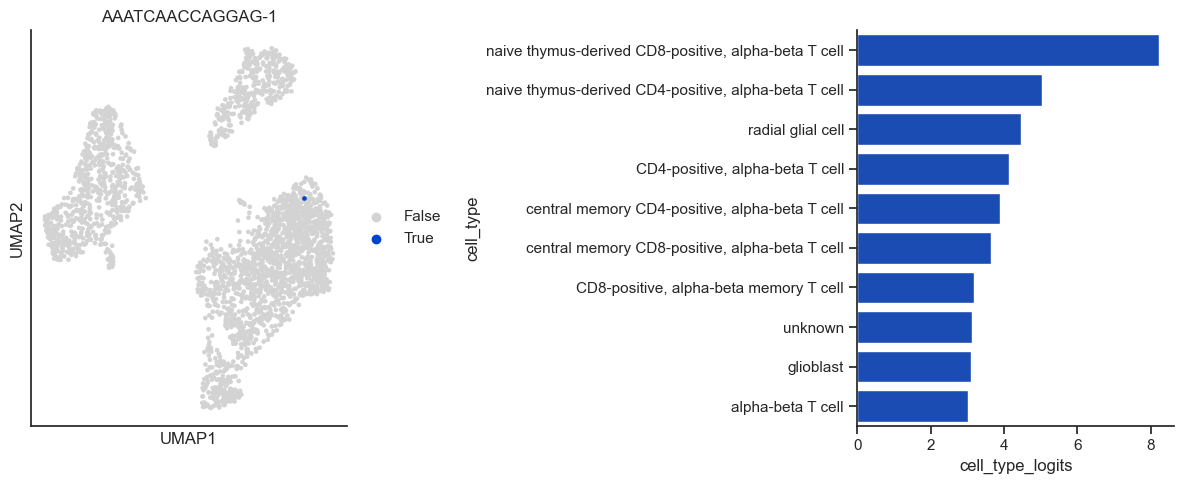

In [15]:
plot_logits("AAATCAACCAGGAG-1", "cell_type", results, label_dict, adata)

## Merge BMFM embedding with original adata object

Now we have observed the cell type prediction, embedding and looked at the cell type predictions in more detail. You might now want to combine this data with your original dataset. 

We can do this by merging the adata objects and setting the embedding and UMAP created by the model through setting the embeddings to `.obsm` from the original `.X`.

There is a helper function `merge_bmfm_adata`:

In [16]:
adata_merged = merge_bmfm_adata(adata, reference_adata)
adata_merged

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_bmfm', 'cell_type_predictions', 'kmeans', 'sub_class_cell_type_predictions', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_bmfm'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
adata_merged.obs.head()

,n_genes,percent_mito,n_counts,louvain_bmfm,cell_type_predictions,kmeans,sub_class_cell_type_predictions,louvain
index,,,,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,T cell,4,T cell,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,mature B cell,7,B cell,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,regulatory T cell,10,T cell,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,"CD14-positive, CD16-positive monocyte",5,monocyte,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,natural killer cell,8,lymphocyte,NK cells


Once merged, you can then overlap gene expression values on the emebeddings to see which clusters/cell types enriched with your gene of interest. 

For example here we are looking CST3 for B-cells, NKG7 for Natural Killer Cells and CD8A for CD8+ T Cells.

<Figure size 1200x800 with 0 Axes>

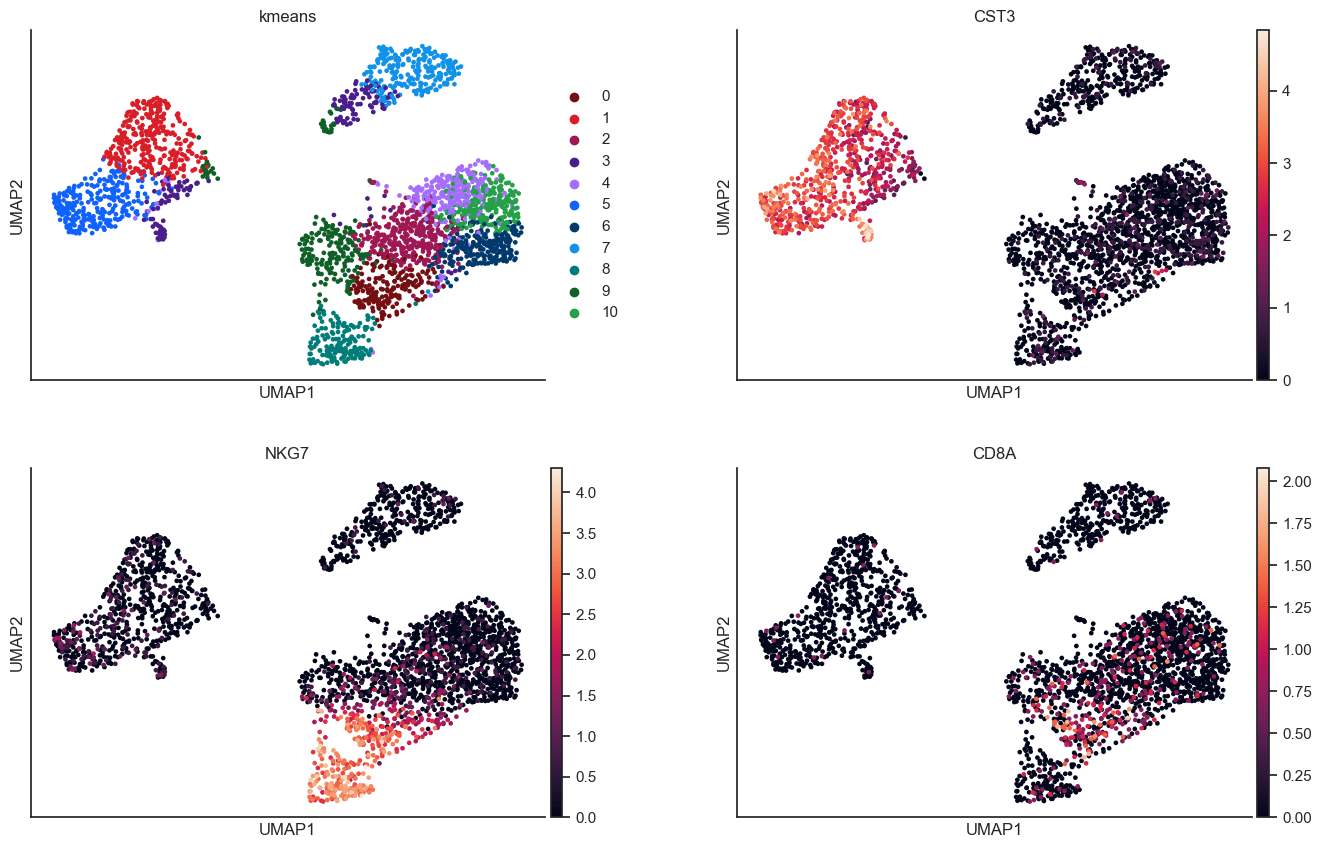

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(12, 8))
sc.pl.umap(
    adata_merged,
    color=["kmeans", "CST3", "NKG7", "CD8A"],
    ncols=2,
    wspace=0.25,
    palette="ibm_carbon",
)
plt.tight_layout()

## Save adata object

Finally, you can save the adata object with the cell types and BMFM embedding using the scanpy's `.write_h5ad()` and save the results from the model as a pickle file.

In [19]:
adata_merged.write_h5ad(results_dir / "bmfm_pbmc3k.h5ad")
with open(results_dir / "bmfm_pbmc3k_results.pkl", "wb") as rf:
    pickle.dump(results, rf)